In [4]:
from tvb.simulator.lab import *
%pylab nbagg
import copy

   INFO  log level set to INFO
Populating the interactive namespace from numpy and matplotlib


In [10]:
import scipy as sp

In [1]:
import pickle

In [16]:
t_frame = 100
dt = 1
n_frame = t_frame / dt
runtime = 10
ic_buffer = 3000

Action log is a collection of parameters that define a given stimulus. Does it need to exist? Yes for simplicity. Probably not in the long term. It could be a polynomial fit or something. Or for now, just discrete actions.

While algorithm is learning, action_log will complement the input data. While algorithm is executing, action_log will be built frame by frame given state information.

Use even numbers for action parameters.

In [9]:
action_log = [('sqr', 5, 100, 50), ('sin', 10, 600), ('sin', 10, 200), ('exp', 3, 200), ('exp', -3, 200)]

In [10]:
#a = translate_action(action_log[0])
t, a, sim, stim = prepare_sim()
#t, d = run_frame(sim, stim, translate_action(action_log[0]))

WARNING  File 'hemispheres' not found in ZIP.


In [11]:
ttest, dtest = run_frame(sim, stim, translate_action(action_log[0], balance_charge = True))

  Time: 0


In [118]:
plot(translate_action(action_log[0], True))

In [81]:
def translate_taylor(x_shift, x_scale, coefficients, repeats = 1):
    action_amps = []

    for i in range(n_frame / repeats):
        x = float(i)
        x_shift = float(x_shift)
        x_scale = float(x_scale)
        y = 0
        for j in range(len(coefficients)):
            y += coefficients[j] * ((x - x_shift)/x_scale) ** j
        action_amps.append(y)
    
    for i in range(repeats-1):
        action_amps = np.concatenate((action_amps, action_amps[0:n_frame/repeats]))
    
    
    return action_amps

<IPython.core.display.Javascript object>


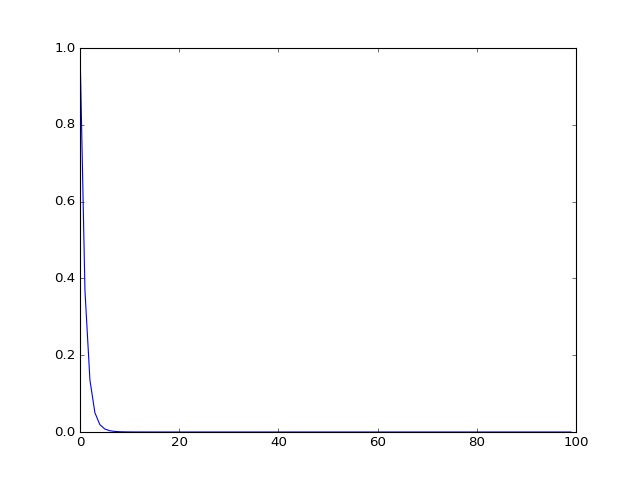

In [90]:
plot(1./np.array(translate_taylor(0,1,[1, 1, 1./2., 1./fact(3), 1./24., 1./(fact(5)), 1./fact(6), 1./fact(7)])))  

In [1]:
#sinusoid:
plot(translate_taylor(25,25/np.pi,[0, 1, 0, -1./fact(3), 0, 1./(fact(5)), 0, -1./fact(7)], repeats = 2))

NameError: name 'plot' is not defined

In [23]:
def fact(x):
    return float(sp.math.factorial(x))

In [3]:
def translate_action(action, balance_charge = True):
    
    action_amps = []
    if action[0] == 'sin':
        wave_amp = action[1]
        period = action[2]        
        for i in range(n_frame):
            action_amps.append( wave_amp * np.sin( (2*np.pi / period) * i ))
        if balance_charge:
            action_amps[n_frame - 1] -= sum(action_amps)
    
    elif action[0] == 'sqr':
        wave_amp = action[1]
        period = action[2]
        pulse_width = action[3]
        for i in range(n_frame):
            if (i*dt) % period  == 0:
                amplitude = wave_amp
                
            elif (i*dt - pulse_width/2) % period == 0:
                amplitude = -wave_amp
            
            elif (i*dt - pulse_width) % period == 0:
                amplitude = 0
                
            action_amps.append(amplitude)
   
    
    return action_amps

In [4]:
def run_frame(sim, stim, action_amps):
    for i in range(n_frame):
        if (i%100 == 0):
            print("  Time: " + str(i))
            
            
            
        #params_dict = {'amp' : action_amps[i], 'T' : dt, 'tau' : dt, 'onset' : dt}
        stim.temporal.parameters["amp"] = action_amps[i]
        #stim.temporal.parameters["T"] = runtime
        #stim.temporal.parameters["tau"] = runtime
        
        (t, d), (te, de), (ti, di) = sim.run(simulation_length = dt)
        
        
        if i == 0:
            t_f = copy.deepcopy(t)
            d_f = copy.deepcopy(d)
            
        else: 
            t_f = np.append(t_f, t, axis = 0)
            d_f = np.append(d_f, d, axis = 0)
    
    return t_f, d_f

In [5]:
def prepare_sim(): 
    epileptic = [9]
    almost_epileptic = []
    stimulus_target = [9]
    stimulus_amplitude = 0
    stimulus_weight = 2 #0-2 for each region
    onset = 0
    period = runtime
    pulse_width = runtime
    frame_length = t_frame
    (s, stimulus) = set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
                  stimulus_weight, onset, period, pulse_width, runtime)


    (t_t, t_d), (aa, aa1), (bb, bb1) = s.run(simulation_length = ic_buffer)

    t_all = copy.copy(t_t)
    d_all = copy.copy(t_d)

    return t_all, d_all, s, stimulus

In [6]:
def set_sim(epileptic, almost_epileptic, target, amp, stim_weight, 
            onset, period, pw, sim_time, K_s=-0.2, K_f=0.1, r_1=0.00015):
  
    #Set up epileptic regions
    epileptors = models.Epileptor(Ks=K_s, Kf=K_f, r=r_1)
    epileptors.x0 = np.ones((76))*-2.4 #set all brain regions non-epileptic
    epileptors.x0[almost_epileptic] = np.ones((2))*-1.9 #overwrite as epileptogenic; borderline epileptic ('close to epilepsy threshold')
    epileptors.x0[epileptic] = np.ones((3))*-1.6 #rHC and lHC are epileptic

    #brain parameters and integration method
    con = connectivity.Connectivity(load_default=True)
    coupl = coupling.Difference(a=1.)
   


    hiss = noise.Additive(nsig = np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
    #heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)
    heunint = integrators.HeunDeterministic(dt=0.05)

    #set up monitors (SEEG and temporal average)
    rm = region_mapping.RegionMapping(load_default=True)
    mon_tavg = monitors.TemporalAverage(period=1.)
    mon_EEG = monitors.EEG(load_default=True,
                       region_mapping=rm,
                       period=1.)
    mon_SEEG = monitors.iEEG(load_default=True,
                             region_mapping=rm,
                             period=1.,
                             ) #intracranial EEG (iEEG) is a particular/specific type of stereoEEG (SEEG)
    what_to_watch = (mon_tavg, mon_EEG, mon_SEEG)
    
    
    #set stimulus to epileptic regions
    weighting = np.ones((76))*0 #np.zeros((76))
    weighting[target] = np.array([stim_weight]) #stimulate rHC and lHC


    #set stimulation paramaeters
    eqn_t = equations.PulseTrain()               #square wave
    eqn_t.parameters["T"] = period             #period
    eqn_t.parameters["onset"] = onset
    eqn_t.parameters["tau"] = pw 
    eqn_t.parameters["amp"] = amp
    stim = patterns.StimuliRegion(temporal = eqn_t,
                          connectivity = con, 
                          weight = weighting)
    
    #Configure space and time
    stim.configure_space()
    stim.configure_time(np.arange(0., sim_time, heunint.dt))

    #Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
    sim = simulator.Simulator(model = epileptors, 
                      connectivity = con,
                      coupling = coupl, 
                      integrator = heunint, 
                      monitors = what_to_watch,
                      stimulus = stim,
                      simulation_length = sim_time)
    sim.configure()
    #plot_pattern(stim)
    return (sim, stim)



def normalize_plot_tavg(ttavg, tavg, regions, descriptive_text, epileptic, almost_epileptic, 
                        target, amp = "var", stim_weight = "var", onset = "var",
                        period = "var", pw = "var"):
        
    tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
    plt.ioff()
    #Plot raw time series
    plt.figure(figsize=(10,8 + len(regions)/2))
    #plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:76], 'r')
    plt.plot(ttavg[:], 0.75*tavg[:, 0, regions, 0] + np.r_[:len(regions)], 'r')
    
    #yticks(np.r_[:76], connectivity.Connectivity(load_default=True).region_labels[:])
    plt.yticks(np.r_[:len(regions)], connectivity.Connectivity(load_default=True).region_labels[regions])   

    plt.title(descriptive_text + "\n Epileptic: " + str(epileptic) + " Borderline: " + str(almost_epileptic) + 
          " Target: " + str(target) + "\n Amplitude: " + str(amp) + 
          " Weight: " + str(stim_weight) + "\n Onset: " + str(onset) + 
          " Period: " + str(period) + " Pulse Width: " + str(pw))
    plt.show()


# In[5]:

def normalize_plot_ieeg(tseeg, seeg, electrodes, descriptive_text, epileptic, almost_epileptic, 
                        target, amp = "var", stim_weight = "var", onset = "var",
                        period = "var", pw = "var"):
    
    seeg /= (np.max(seeg, 0) - np.min(seeg, 0))
    seeg -= np.mean(seeg, 0)
    
    plt.figure(figsize=(10,8 + len(electrodes)/2))
    plt.plot(tseeg[:], 3*seeg[:,0, electrodes, 0] + 2*np.r_[:len(electrodes)])
    plt.yticks(2*np.r_[:len(electrodes)],  monitors.iEEG(load_default=True,
                                  region_mapping=region_mapping.RegionMapping(load_default=True),
                                  period=1.,).sensors.labels[electrodes])
    
    
    plt.title(descriptive_text + "\n Epileptic: " + str(epileptic) + " Borderline: " + str(almost_epileptic) + 
          " Target: " + str(target) + "\n Amplitude: " + str(amp) + 
          " Weight: " + str(stim_weight) + "\n Onset: " + str(onset) + 
          " Period: " + str(period) + " Pulse Width: " + str(pw))
    plt.show()
    


# In[6]:

def normalize_plot_eeg(teeg, eeg, electrodes, descriptive_text, epileptic, almost_epileptic, 
                        target, amp = "var", stim_weight = "var", onset = "var",
                        period = "var", pw = "var"):
    
    eeg /= (np.max(eeg, 0) - np.min(eeg, 0))
    eeg -= np.mean(eeg, 0)
    
    plt.figure(figsize=(20,8 + len(electrodes)/2))
    plt.plot(teeg[:], 3*eeg[:,0, electrodes, 0] + 2*np.r_[:len(electrodes)])
    plt.yticks(2*np.r_[:len(electrodes)],  monitors.EEG(load_default=True,
                                  region_mapping=region_mapping.RegionMapping(load_default=True),
                                  period=1.,).sensors.labels[electrodes])
    
    
    plt.title(descriptive_text + "\n Epileptic: " + str(epileptic) + " Borderline: " + str(almost_epileptic) + 
          " Target: " + str(target) + "\n Amplitude: " + str(amp) + 
          " Weight: " + str(stim_weight) + "\n Onset: " + str(onset) + 
          " Period: " + str(period) + " Pulse Width: " + str(pw))
    plt.show()
    

def save_fig_and_data(ttavg, tavg, regions, descriptive_text, epileptic, 
                      almost_epileptic, target, amp = "var", stim_weight = "var", 
                      onset = "var", period = "var", pw = "var"):
    tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
    plt.ioff()
    plt.figure(figsize=(10,8 + len(regions)/2))
    plt.plot(ttavg[:], tavg[:, 0, regions, 0] + np.r_[:len(regions)], 'r')
    plt.yticks(np.r_[:len(regions)], connectivity.Connectivity(load_default=True)
.region_labels[regions])
    plt.title(descriptive_text + "\n Epileptic: " + str(epileptic) + " Borderline: " + str(almost_epileptic) + 
          " Target: " + str(target) + "\n Amplitude: " + str(amp) + 
          " Weight: " + str(stim_weight) + "\n Onset: " + str(onset) + 
          " Period: " + str(period) + " Pulse Width: " + str(pw))
    
    plt.savefig('Graphs/' + descriptive_text + "-amp" + str(amp) + "-stim_wgt" + str(stim_weight))
    
    outfile = open('Graphs/' + descriptive_text + "-amp" + str(amp) + "-stim_wgt" + str(stim_weight) + '.txt', "w+")
    
    for time, value in zip(ttavg, tavg):
                outfile.write(str(time) + ' \t')
                for sensor in value[0]:
                    outfile.write(str(sensor[0]) + '\t')
                outfile.write('\n')
    outfile.close()